In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gamma
from numpy.typing import ArrayLike

### Example Data ###

We assume 5 income classes with a left-skewed multinomial distribution. Income is to be considered as the after taxes monthly salary.

In [2]:
inc_classes = ["500 - 1500", "1501 - 2500", "2501 - 3500", "3501 - 5500", "5501 - 7500"]
frequencies = [0.1, 0.4, 0.3, 0.15, 0.05]  # Example frequencies for each bin

data = pd.DataFrame(
    {
        "income_class": inc_classes,
        "frequency": frequencies
    }
)

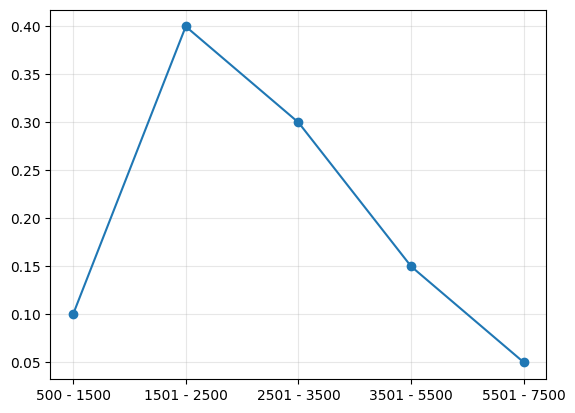

In [3]:
_ = plt.plot(data["income_class"], data["frequency"], marker="o")
_ = plt.grid(alpha=.3)

### Individual Incomes Distribution ###

Here we sample the individual income using a left-skewed gamma distribution. We consider the post taxation monthly income and, for simplicity, we force the values to lay within the range $500-$7500.

In [4]:
def simulate_income_left_skewed(
    n: int = 1000, 
    min_income: int | float = 500, 
    max_income: int | float = 7500, 
    median: int | float = 1850
) -> np.ndarray:
    """
    Simulates a left-skewed distribution for post-taxation monthly income
    with narrower density and less spread.
    
    Parameters:
        n (int): Number of samples to generate.
        min_income (float): Minimum income value.
        max_income (float): Maximum income value.
        median (float): Target median income value.
        
    Returns:
        np.ndarray: Array of simulated incomes.
    """
    # Parameters for the Gamma distribution
    shape = 3  # Controls skewness (lower -> more skewed)
    scale = (median - min_income) / shape  # Adjust scale based on the median
    loc = min_income  # Minimum income corresponds to the location parameter

    # Generate raw Gamma-distributed values
    raw_data = gamma.rvs(shape, loc=loc, scale=scale, size=n)

    # Clip to the desired range to ensure values stay within bounds
    clipped_data = np.clip(raw_data, min_income, max_income)

    return clipped_data

# Generate and visualize simulated incomes
income_samples = simulate_income_left_skewed(n=10000)

In [66]:
def gini_index(income: ArrayLike):
    """
    Computes the Gini index for a given income distribution.
    
    Parameters:
        income (np.ndarray): Array of income values.
        
    Returns:
        float: Gini index (0 = perfect equality, 1 = perfect inequality).
    """
    # Sort incomes in ascending order
    income = np.sort(income)
    
    # Number of observations
    n = len(income)
    
    # Mean income
    mean_income = np.mean(income)
    
    # Compute the Gini index using the formula
    diff_sum = np.sum(np.abs(income[:, None] - income))  # Pairwise absolute differences
    gini = diff_sum / (2 * n**2 * mean_income)
    
    return gini

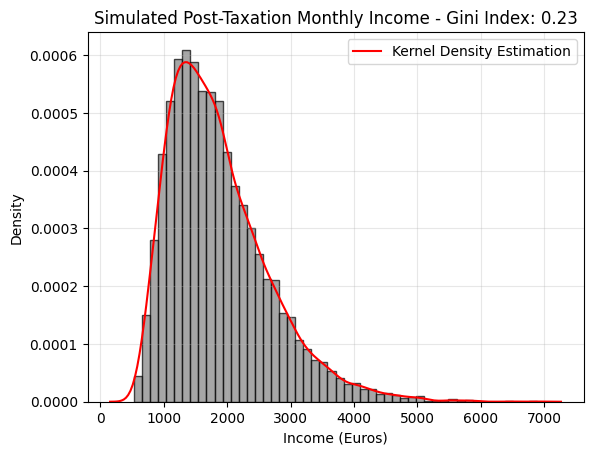

In [72]:
sns.kdeplot(income_samples, c="r", label="Kernel Density Estimation")
plt.grid(alpha=.3)
plt.hist(income_samples, bins=50, density=True, color='gray', alpha=0.7, edgecolor='black')
plt.title(
    f'Simulated Post-Taxation Monthly Income - Gini Index: {gini_index(income_samples):.2f}'
)
plt.xlabel('Income (Euros)')
plt.ylabel('Density')
plt.legend()
plt.show()

### The Progressive Consumption Tax ###

We use a continuous function to assign the consumption tax to each individual income. For a matter of semplicity, we assume a constant baseline consumption tax of 0.22 (22%).

Here, we propose a scaled logistic function based tax. A scaled logistic function has some interesting properties that make it a good candidate for simulating a progressive tax:
- First, the scaling procedure allows to consider a lower and an upper limit.
- It naturally maps data from the R line to [0, 1].
- Maximum and minimum values can be selected.
- The steepness factor allows to consider different levels of progressivity.

In [62]:
def scaled_sigmoid(x, a, b, x_min, x_max, k=0.001):
    x_mid = (x_min + x_max) / 2
    return a + (b - a) / (1 + np.exp(-k * (x - x_mid)))


a, b, k = 0.15, 0.35, 0.0007
cons_tax = scaled_sigmoid(sorted(income_samples), a, b, min(income_samples), max(income_samples), k=k)

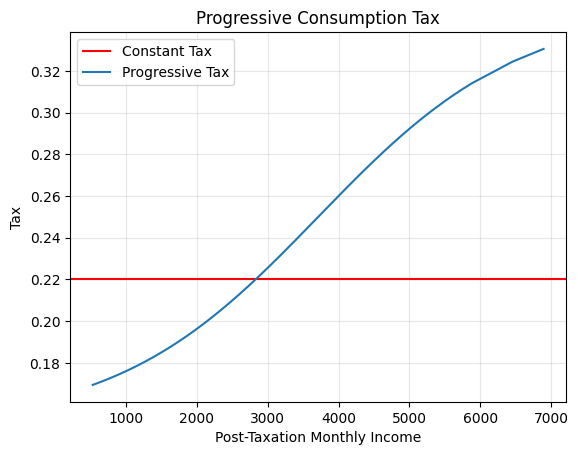

In [63]:
plt.axhline(.22, color="r", label="Constant Tax")
plt.plot(sorted(income_samples), cons_tax, label="Progressive Tax")
plt.title("Progressive Consumption Tax")
plt.xlabel("Post-Taxation Monthly Income")
plt.ylabel("Tax")
plt.legend()
plt.grid(alpha=.3)
plt.show()

### Consumption Goods Prices Distribution ###

For the consumption goods' prices distribution, we use data shared by the [Sparks Foundation](https://www.thesparksfoundationsingapore.org/), available on kaggle at the following URL: https://www.kaggle.com/datasets/roopacalistus/superstore. The data represent a series of about 10k retail transactions that took place in the US.

Here, we suppose that the transactions are limited to goods whose prices are within the range $1-$800.

In [28]:
ret2 = pd.read_csv("../data/SampleSuperstore.csv")
ret2 = ret2[(ret2["Sales"] >= 1) & (ret2["Sales"] <= 800)].reset_index(drop=True)

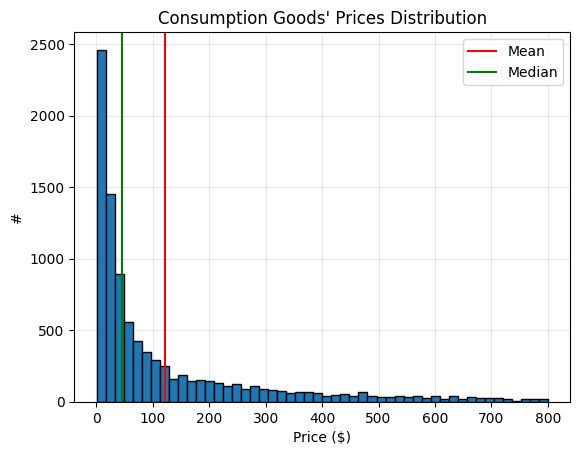

In [64]:
ret2["Sales"].hist(bins=50, edgecolor="k", grid=False, zorder=2)
plt.axvline(ret2["Sales"].mean(), c="r", label="Mean")
plt.axvline(ret2["Sales"].median(), c="g", label="Median")
plt.xlabel("Price ($)")
plt.ylabel("#")
plt.title("Consumption Goods' Prices Distribution")
plt.legend()
plt.grid(alpha=.3, zorder=-2)

### The Simulation ###

Here we perform the simulation of the economic system. Our main statement is that the introduction of a progressive taxation on consumption goods - represented by the above sigmoid function - at time $t$ would result in more redistributive power for the government at $t+1$. In fact, assuming that the extra budget gathered from an higher taxation for some income classes can be entirely redistributed to lower income individuals at $t + 1$, one can compare the pre and post introduction gini indexes of the income distributions and assess the pre and post introduction inequality. The core assumptions are:
1. The saving rate ($\gamma$) is constant and equal to 20%  of the monthly income.
2. Each economic agent has a monthly income randomly sampled from a gamma distribution clipped between 500 and 7500.
3. At $t$, each economic agent spends his/her income ($Y$) in consumption goods until he/she reaches $(1 - \gamma)*Y$
4. For each consumption good bought, two scenarios are created:
    - One: a taxation ($\omega$), defined by the above sigmoid function is paid.
    - Two: a constant 22% taxation is paid.
5. At $t+1$, the government redistributes the extra budget to lower income individuals, with an amount inversely proportional to the baseline (at $t$) individual income.